In [126]:
# dependencies

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import datetime as dt
from collections import defaultdict

In [3]:
# reflect tables into SQLAlchemy ORM

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

database_path = "/Users/kinlaydenning/Documents/bootcamp2022/week_10_advanced_database_storage_and_retrieval/sqlalchemy-challenge/hawaii.sqlite"
engine = create_engine(f"sqlite:///{database_path}")

In [4]:
# create an inspector and connect to engine

inspector = inspect(engine)

# return table names using inspector
inspector.get_table_names()


['measurement', 'station']

In [5]:
# Using the inspector to print the column names within the measurement table and station table
measurement_columns = inspector.get_columns('measurement')
print('----------Measurement Table------------')
for column in measurement_columns:
    print(column["name"], column["type"])

print('----------Station Table------------')
station_columns = inspector.get_columns('station')
for column in station_columns:
    print(column["name"], column["type"])


----------Measurement Table------------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
----------Station Table------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [6]:
# Reflect database into ORM class
base = automap_base()
base.prepare(engine, reflect=True)
measurement = base.classes.measurement
station = base.classes.station

# create a session
session = Session(engine)

In [7]:
## Exploratory Climate Analysis:

    # Find the last point in the database
session.query(measurement.date, measurement.prcp).order_by(measurement.date.desc()).first()

('2017-08-23', 0.0)

In [125]:
# query data and percipitation from measurement table

date_percp = [measurement.date,
            measurement.prcp]

precp_data = session.query(*date_percp).\
    filter(measurement.date >= '2016-08-23').\
        order_by(measurement.date).all()


In [93]:
# transform precipation data to dataframe

precp_df = pd.DataFrame(precp_data, columns=['date', 'prcp']).rename(columns={'prcp': 'precipitation'})
precp_df.dropna(inplace=True)
gb1 = precp_df.groupby('date')['precipitation'].sum()
p_sum_df = pd.DataFrame(gb1).reset_index()
p_sum_df['date'] = pd.to_datetime(p_sum_df['date'])
p_sum_df.head()


,date,precipitation
0,2016-08-23,2.71
1,2016-08-24,9.33
2,2016-08-25,0.54
3,2016-08-26,0.10
4,2016-08-27,0.32


In [90]:
# summary statistics
resample = p_sum_df.resample('7D', on='date').agg({'precipitation': 'sum'}).reset_index()
resample['date'] = pd.to_datetime(resample['date']).dt.date
week_p_df = pd.DataFrame(resample).set_index('date')
week_p_df.describe()

,precipitation
count,53.000000
mean,6.760000
std,6.967203
min,0.020000
25%,2.050000
50%,4.320000
75%,8.590000
max,33.100000


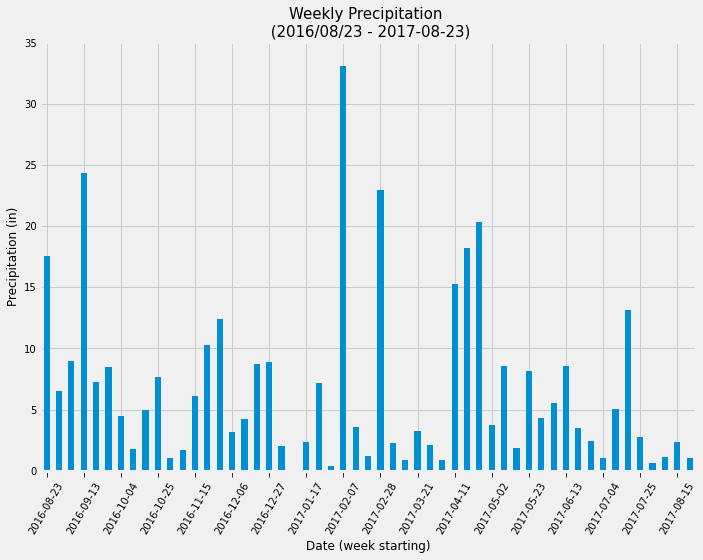

In [120]:
# plot precipitation data as bar chart

week_p_df.plot(kind='bar', figsize=(10,8), legend=None)
plt.locator_params(axis='x', nbins=26)
plt.tick_params(axis='x', length=6)
plt.xticks(rotation=60, fontsize=10)
plt.yticks(np.arange(0, 40, step=5), fontsize=10)
plt.title("Weekly Precipitation \n (2016/08/23 - 2017-08-23)", fontsize=15)
plt.xlabel("Date (week starting)", fontsize=12)
plt.ylabel("Precipitation (in)", fontsize=12)
plt.tight_layout()
plt.show()


In [91]:
## Station Analysis

# most active stations
station_data = [measurement.station,
            station.name,
            func.count(station.name)]

station_query = session.query(*station_data).\
    filter(measurement.station == station.station).\
        group_by(station.name).\
        order_by(func.count(station.name).desc()).all()
station_df = pd.DataFrame(station_query)
station_df

,0,1,2
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
7,USC00517948,"PEARL CITY, HI US",1372
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",511


In [95]:
# highest temp, lowest temp, ave temp most active station
active_station_data = [measurement.station,
                    func.avg(measurement.tobs),
                    func.max(measurement.tobs),
                    func.min(measurement.tobs)]

active_station_query = session.query(*active_station_data).\
    filter(measurement.station == "USC00519281").\
    group_by(measurement.station).all()
active_station_query


[('USC00519281', 71.66378066378067, 85.0, 54.0)]

In [96]:
# temp observation data for most active station

date_temp_query = session.query(measurement.tobs).\
    filter(measurement.date >= '2016-08-23').\
    filter(measurement.station == 'USC00519281').all()
date_temp_query

d_df = pd.DataFrame(date_temp_query, columns=['tobs'])
d_df

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


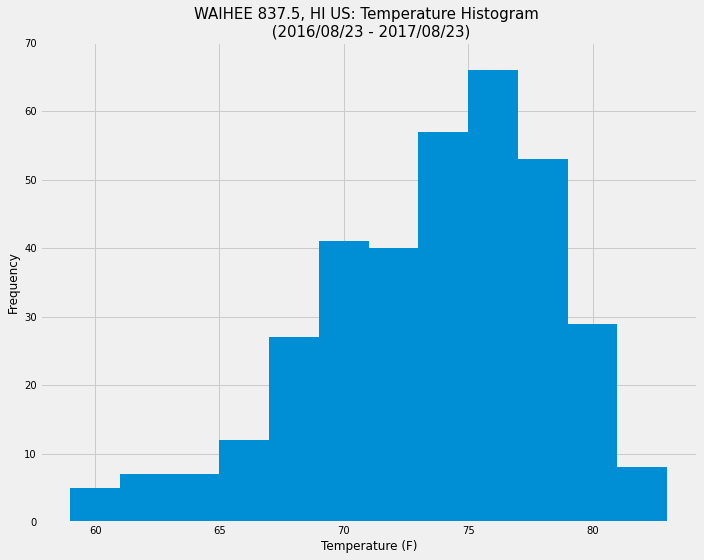

In [123]:
# histogram

d_df.hist(column='tobs', bins=12, figsize=(10,8))
plt.title("WAIHEE 837.5, HI US: Temperature Histogram \n (2016/08/23 - 2017/08/23)", fontsize=15)
plt.xlabel("Temperature (F)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(np.arange(0, 80, step=10), fontsize=10)
plt.tight_layout()
plt.show()

In [128]:
results = session.query(measurement.date, measurement.prcp).all()
results


[('2010-01-01', 0.08),
 ('2010-01-02', 0.0),
 ('2010-01-03', 0.0),
 ('2010-01-04', 0.0),
 ('2010-01-06', None),
 ('2010-01-07', 0.06),
 ('2010-01-08', 0.0),
 ('2010-01-09', 0.0),
 ('2010-01-10', 0.0),
 ('2010-01-11', 0.01),
 ('2010-01-12', 0.0),
 ('2010-01-14', 0.0),
 ('2010-01-15', 0.0),
 ('2010-01-16', 0.0),
 ('2010-01-17', 0.0),
 ('2010-01-18', 0.0),
 ('2010-01-19', 0.0),
 ('2010-01-20', 0.0),
 ('2010-01-21', 0.0),
 ('2010-01-22', 0.0),
 ('2010-01-23', 0.0),
 ('2010-01-24', 0.01),
 ('2010-01-25', 0.0),
 ('2010-01-26', 0.04),
 ('2010-01-27', 0.12),
 ('2010-01-28', 0.0),
 ('2010-01-30', None),
 ('2010-01-31', 0.03),
 ('2010-02-01', 0.01),
 ('2010-02-03', None),
 ('2010-02-04', 0.01),
 ('2010-02-05', 0.0),
 ('2010-02-06', 0.0),
 ('2010-02-07', 0.0),
 ('2010-02-08', 0.0),
 ('2010-02-09', 0.0),
 ('2010-02-11', 0.0),
 ('2010-02-12', 0.02),
 ('2010-02-13', 0.01),
 ('2010-02-14', 0.0),
 ('2010-02-15', 0.0),
 ('2010-02-16', 0.0),
 ('2010-02-17', 0.0),
 ('2010-02-19', None),
 ('2010-02-20', 0

In [137]:
d = {}
for date, prcp in results:
    if type(prcp) == float:
        d.setdefault(date, []).append(prcp)
d


dict_keys(['2010-01-01', '2010-01-02', '2010-01-03', '2010-01-04', '2010-01-07', '2010-01-08', '2010-01-09', '2010-01-10', '2010-01-11', '2010-01-12', '2010-01-14', '2010-01-15', '2010-01-16', '2010-01-17', '2010-01-18', '2010-01-19', '2010-01-20', '2010-01-21', '2010-01-22', '2010-01-23', '2010-01-24', '2010-01-25', '2010-01-26', '2010-01-27', '2010-01-28', '2010-01-31', '2010-02-01', '2010-02-04', '2010-02-05', '2010-02-06', '2010-02-07', '2010-02-08', '2010-02-09', '2010-02-11', '2010-02-12', '2010-02-13', '2010-02-14', '2010-02-15', '2010-02-16', '2010-02-17', '2010-02-20', '2010-02-21', '2010-02-22', '2010-02-23', '2010-02-24', '2010-02-25', '2010-02-26', '2010-02-28', '2010-03-01', '2010-03-02', '2010-03-03', '2010-03-04', '2010-03-05', '2010-03-06', '2010-03-07', '2010-03-08', '2010-03-09', '2010-03-12', '2010-03-13', '2010-03-14', '2010-03-15', '2010-03-17', '2010-03-18', '2010-03-21', '2010-03-22', '2010-03-23', '2010-03-24', '2010-03-27', '2010-03-28', '2010-03-29', '2010-03-